In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
import datetime as dt


#from data_handler import get_sp500_ticker_list
from data_handler import get_adj_close
#from data_handler import sp500_closes_to_csv

from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

In [2]:
# Setting some default layout options for plots
sns.set_style("whitegrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

# Getting the data

In [3]:
start='2018-01-01'
end='2020-12-31'
interval='1d'
ticker_list = ['AAPL', 'NVDA', 'FTNT']

df = get_adj_close(ticker_list, start, end, interval)

[*********************100%***********************]  3 of 3 completed


In [4]:
df.head()

,AAPL,FTNT,NVDA
Date,,,
2018-01-02,41.135757,44.349998,49.372395
2018-01-03,41.128593,45.029999,52.621777
2018-01-04,41.319626,44.000000,52.899170
2018-01-05,41.790066,44.099998,53.347439
2018-01-08,41.634857,45.000000,54.982052


# Analyze data

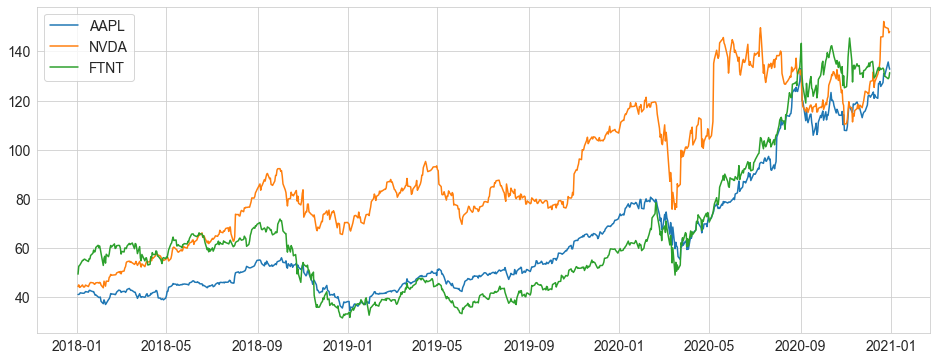

In [5]:
#plotting adjusted close price
plt.plot(df)
plt.legend(ticker_list)
plt.show()

In [6]:
#Computing the daily returns
returns = (df.pct_change())*100
returns.dropna(axis=0,inplace=True)
print(returns)

                AAPL      FTNT      NVDA
Date                                    
2018-01-03 -0.017416  1.533259  6.581374
2018-01-04  0.464476 -2.287361  0.527146
2018-01-05  1.138539  0.227269  0.847403
2018-01-08 -0.371401  2.040820  3.064089
2018-01-09 -0.011489 -1.511112 -0.027045
...              ...       ...       ...
2020-12-23 -0.697599 -1.255333 -2.025869
2020-12-24  0.771227 -0.299529 -0.119129
2020-12-28  3.576588 -0.333801 -0.721525
2020-12-29 -1.331504 -1.178910  0.335262
2020-12-30 -0.852669  0.332140  1.564546

[754 rows x 3 columns]


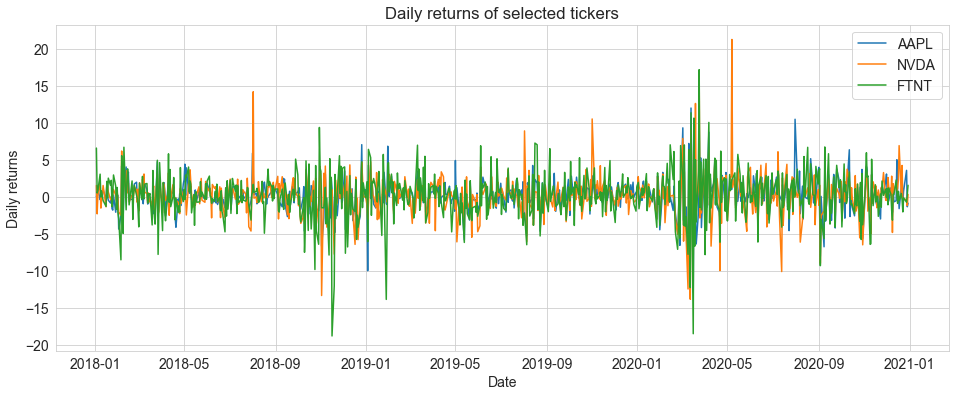

In [7]:
#plotting the returns
plt.plot(returns)
plt.title('Daily returns of selected tickers')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.legend(ticker_list)
plt.show()

C:\Users\antoi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


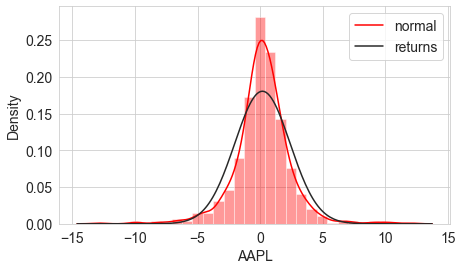

In [53]:
#plotting histograms to inspect distribution of the returns. We can clearly see fatter tails
plt.figure(figsize=(7,4))
sns.distplot(returns['AAPL'], norm_hist=True, fit=stats.norm, bins=30, color='r')
plt.legend(('normal', 'returns'))
plt.show()

In [ ]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [ ]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [ ]:
plot_correlogram(returns['AAPL'],lags=100, title="AAPL")

In [9]:
#Creating train and test sets (not the best way to proceed...)
#train_aapl = df.loc["2018-01-01":"2020-11-30","AAPL"]
#test_aapl = df.loc["2020-12-01":"2020-12-31","AAPL"]
#test_aapl

In [10]:
split_date = dt.datetime(2020,12,1)

# Modelling volatility with GARCH

In [11]:
#finding the best parameters
aic_garch = []

for p in range(1, 11): 
    for q in range(1,11):
        garch = arch_model(returns['AAPL'], mean='zero', vol='GARCH', p=p, q=q)\
            .fit(disp='off') 
        aic_garch.append(garch.aic) 
    
        if garch.aic == np.min(aic_garch): 
            best_param = (p,q) 
print(best_param) 

(3, 3)


In [12]:
#fitting the GARCH model on the train data set
garch = arch_model(returns['AAPL'], mean='zero', vol='GARCH', p=best_param[0], q=best_param[1])
garch_results = garch.fit(disp='off', last_obs=split_date)
print(garch_results.summary)

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1514.14
Distribution:                  Normal   AIC:                           3042.28
Method:            Maximum Likelihood   BIC:                           3074.46
                                        No. Observations:                  733
Date:                Sun, Apr 24 2022   Df Residuals:                      733
Time:                        10:34:28   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.539

# Analytical forecasts

<AxesSubplot:xlabel='Date'>

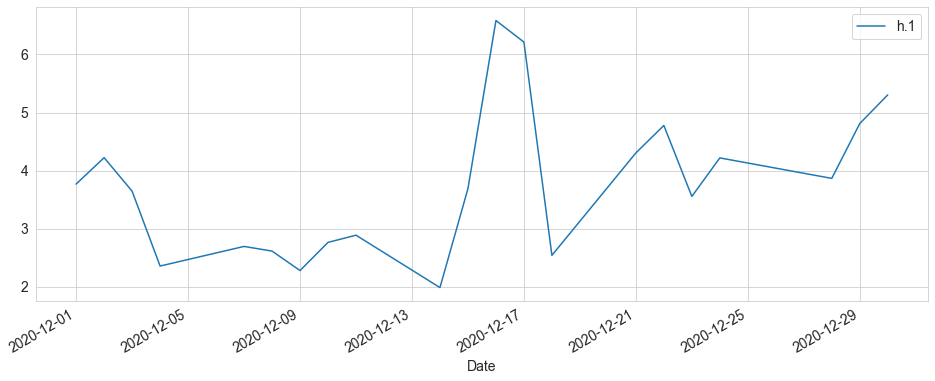

In [47]:
forecasts_aapl = garch_results.forecast(horizon=1, start=split_date, reindex=False)
forecasts_aapl.variance[split_date:].plot()

In [39]:
print(forecasts_aapl.variance)

                 h.1       h.2       h.3
Date                                    
2020-12-01  3.767670  4.474237  4.630835
2020-12-02  4.223018  3.933752  3.380604
2020-12-03  3.646473  2.583460  3.382979
2020-12-04  2.356134  2.752192  2.940973
2020-12-07  2.694149  2.779912  2.620093
2020-12-08  2.613760  2.159051  2.488577
2020-12-09  2.278864  2.821038  3.204691
2020-12-10  2.763613  3.045347  2.601812
2020-12-11  2.887719  2.164424  2.608742
2020-12-14  1.985452  2.112128  2.461677
2020-12-15  3.688717  6.836408  7.327879
2020-12-16  6.584909  6.630018  3.947993
2020-12-17  6.213777  2.793004  5.073576
2020-12-18  2.540441  4.372761  4.708127
2020-12-21  4.304252  4.518028  3.128763
2020-12-22  4.777188  3.847882  5.233106
2020-12-23  3.555112  4.420727  3.841591
2020-12-24  4.218726  3.281078  3.330438
2020-12-28  3.866083  4.953714  5.979279
2020-12-29  4.810884  5.582952  3.964390
2020-12-30  5.304287  3.191149  4.141699


# Simulation forecasts

<AxesSubplot:xlabel='Date'>

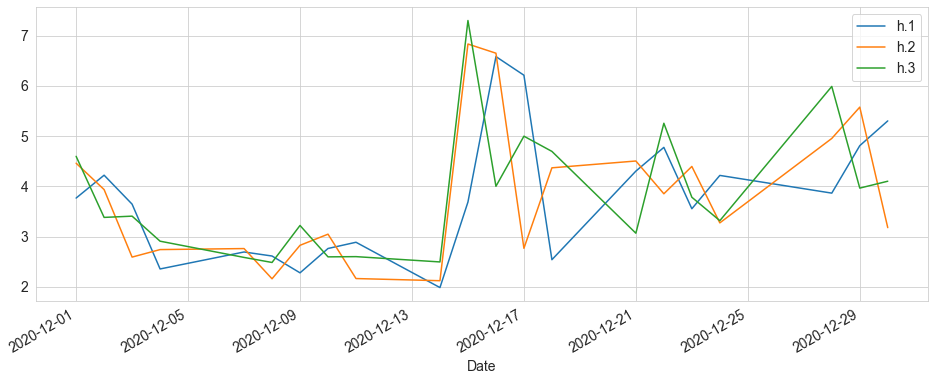

In [15]:
simu_forecasts_aapl = garch_results.forecast(horizon=3, start=split_date, method="simulation", reindex=False)
simu_forecasts_aapl.variance[split_date:].plot()

In [45]:
#computing realized volatility
realized_vol = returns.loc[(split_date-dt.timedelta(7)):,:].rolling(5).std()
realized_vol

,AAPL,FTNT,NVDA
Date,,,
2020-11-24,NaN,NaN,NaN
2020-11-25,NaN,NaN,NaN
2020-11-27,NaN,NaN,NaN
2020-11-30,NaN,NaN,NaN
2020-12-01,1.071707,1.546059,1.315303
2020-12-02,1.205448,1.561821,0.877845
2020-12-03,1.362996,1.784015,0.910962
2020-12-04,1.560441,1.327126,1.004099
2020-12-07,1.443671,1.217568,0.946010


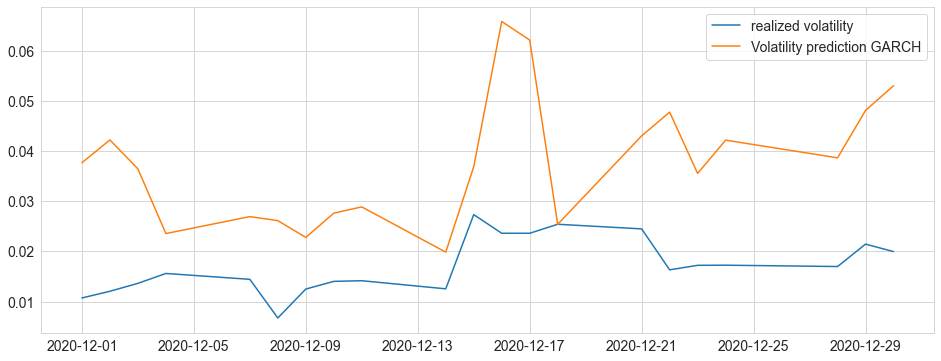

In [49]:
#plotting realized volatility vs volatility prediction with GARCH
plt.plot(realized_vol['AAPL'] /100, label="realized volatility")
plt.plot(forecasts_aapl.variance/100, label="Volatility prediction GARCH")
plt.legend()
plt.show()

# EGARCH

In [77]:
aic_egarch = []

for p in range(1, 11):
    for q in range(1, 11):
        egarch = arch_model(returns['AAPL'], mean='zero', vol='EGARCH', p=p, q=q)\
              .fit(disp='off')
        aic_egarch.append(egarch.aic)
        if egarch.aic == np.min(aic_egarch):
            best_param = (p, q)
print(best_param)

(3, 3)


In [82]:
egarch = arch_model(returns['AAPL'], mean='zero', vol='EGARCH',
                 p=best_param[0], q=best_param[1])\
      .fit(disp='off',last_obs=split_date)
print(egarch.summary())
forecasts_egarch = egarch.forecast(start=split_date)

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -1511.26
Distribution:                  Normal   AIC:                           3036.53
Method:            Maximum Likelihood   BIC:                           3068.71
                                        No. Observations:                  733
Date:                Sun, Apr 24 2022   Df Residuals:                      733
Time:                        12:35:53   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2370      0.107      2.205  2.747e-02 [2.631e-0

C:\Users\antoi\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


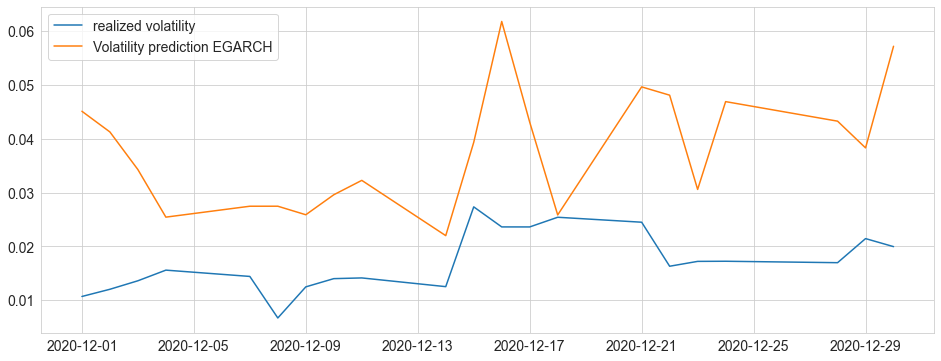

In [83]:
#plotting realized volatility vs volatility prediction with GARCH
plt.plot(realized_vol['AAPL'] /100, label="realized volatility")
plt.plot(forecasts_egarch.variance/100, label="Volatility prediction EGARCH")
plt.legend()
plt.show()